<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/13a_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network con MultiLayer perceptrón

Un modelo de red adversarial generativa (GAN) consta de dos modelos:

*    Una **red generadora** G que toma una incrustación latente (generalmente ruido aleatorio) y genera una imagen como las que existen en los datos de entrenamiento
*    Una **red discriminadora** D que trata de distinguir entre imágenes reales de los datos de entrenamiento e imágenes falsas producidas por el generador.


En esencia, tenemos dos redes neuronales que son adversarias: **el generador quiere engañar al discriminador y el discriminador quiere evitar ser engañado**. La configuración se conoce como un juego min-max.

A continuación se describe un generador simple y un discriminador:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms

## Conjunto de datos

In [2]:
mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Modelo

Tanto el Discriminador como el Generador son redes totalmente conectadas.

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 300),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(300, 100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, 1)
            
            #nn.Linear(784, 300),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.3),
            #nn.Linear(300, 200),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.3),
            #nn.Linear(200, 100),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Dropout(0.3),
            #nn.Linear(100, 1),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.model(x)
        return out.view(x.size(0))

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 300),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(300, 28*28),
            nn.Sigmoid()
            
            #nn.Linear(100, 300),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Linear(300, 300),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Linear(300, 28*28),
            #nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x).view(x.size(0), 1, 28, 28)
        return out

### Training

In [4]:
from torch.autograd import Variable

def train(generator, discriminator, lr=0.001, num_epochs=5):
    criterion = nn.BCEWithLogitsLoss()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

    train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=100, shuffle=True)

    num_test_samples = 16
    test_noise = torch.randn(num_test_samples, 100).to(device)
    num_fig = 0 #

    for epoch in range(num_epochs):
        # label that we are using both models 
        generator.train()
        discriminator.train()


        for n, (images, _) in enumerate(train_loader):
            images = Variable(images.to(device))
            
            # === Train the Discriminator ===

            noise = torch.randn(images.size(0), 100).to(device)
            fake_images = Variable(generator(noise))
            
            inputs = torch.cat([images, fake_images.to(device)])
            labels = torch.cat([Variable(torch.zeros(images.size(0))), # real
                                Variable(torch.ones(images.size(0)))]).to(device) # fake

            d_outputs = discriminator(inputs)
            d_loss = criterion(d_outputs, labels)
            d_loss.backward()
            d_optimizer.step()
            d_optimizer.zero_grad()

            # === Train the Generator ===
            noise = torch.randn(images.size(0), 100).to(device)
            fake_images = generator(noise)
            outputs = discriminator(fake_images)

            g_loss = criterion(outputs, torch.zeros(images.size(0)).to(device))
            g_loss.backward()
            g_optimizer.step()
            g_optimizer.zero_grad()

        scores = torch.sigmoid(d_outputs)
        # print (f"images.size(0): {images.size(0)}")
        real_score = scores[:images.size(0)].data.mean()
        fake_score = scores[images.size(0):].data.mean()


        print(f"Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score:.2f}, D(G(z)): {fake_score:.2f}")
        
        # plot images
        generator.eval()
        discriminator.eval()
        test_images = generator(test_noise)
        plt.figure(figsize=(9, 3))
        for k in range(16):
            plt.subplot(2, 8, k+1)
            plt.imshow(test_images[k,:].cpu().data.numpy().reshape(28, 28), cmap='Greys')
        plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

print (discriminator)

print (generator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=300, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=300, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


Epoch [1/20], d_loss: 0.5609, g_loss: 0.3992, D(x): 0.01, D(G(z)): 0.33


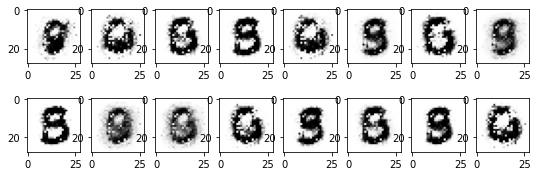

Epoch [2/20], d_loss: 0.5665, g_loss: 0.4140, D(x): 0.03, D(G(z)): 0.33


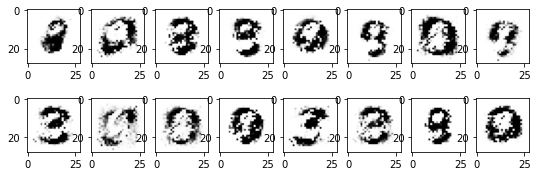

Epoch [3/20], d_loss: 0.6195, g_loss: 0.4527, D(x): 0.06, D(G(z)): 0.33


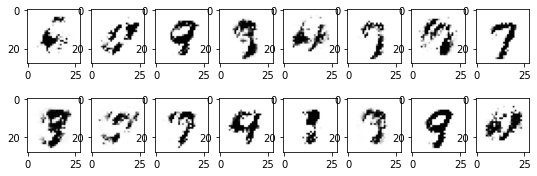

Epoch [4/20], d_loss: 0.6838, g_loss: 0.3441, D(x): 0.10, D(G(z)): 0.29


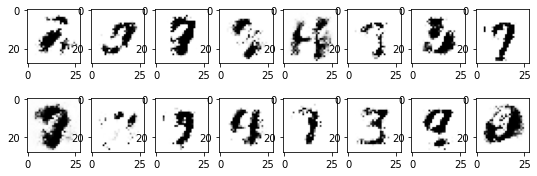

Epoch [5/20], d_loss: 0.6662, g_loss: 0.3420, D(x): 0.07, D(G(z)): 0.30


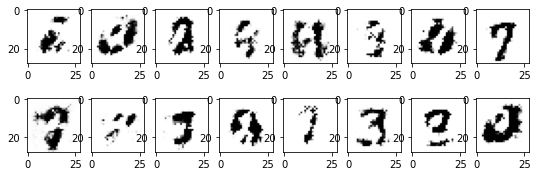

Epoch [6/20], d_loss: 0.6536, g_loss: 0.3443, D(x): 0.06, D(G(z)): 0.30


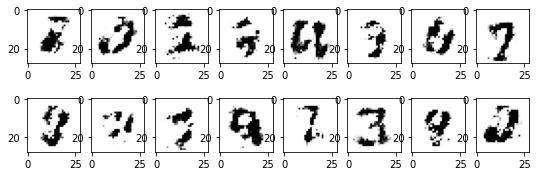

Epoch [7/20], d_loss: 0.6688, g_loss: 0.3693, D(x): 0.07, D(G(z)): 0.29


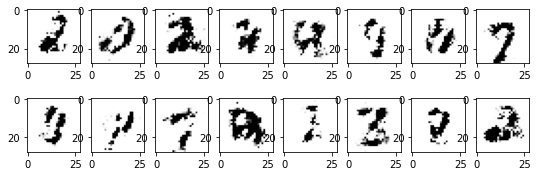

Epoch [8/20], d_loss: 0.6505, g_loss: 0.3636, D(x): 0.06, D(G(z)): 0.30


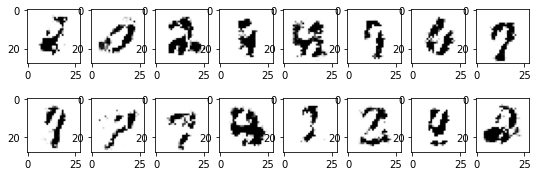

Epoch [9/20], d_loss: 0.6550, g_loss: 0.3519, D(x): 0.07, D(G(z)): 0.30


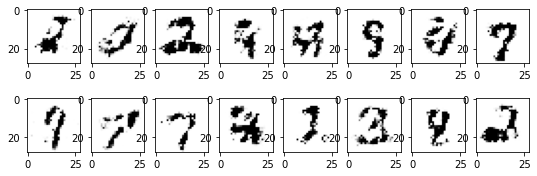

Epoch [10/20], d_loss: 0.6447, g_loss: 0.3655, D(x): 0.08, D(G(z)): 0.31


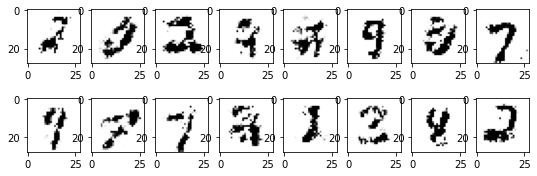

Epoch [11/20], d_loss: 0.6581, g_loss: 0.3419, D(x): 0.06, D(G(z)): 0.29


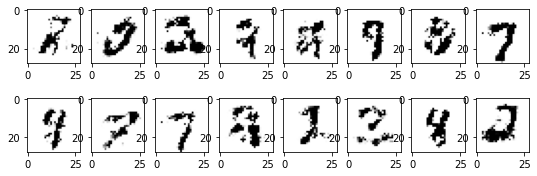

Epoch [12/20], d_loss: 0.6798, g_loss: 0.3756, D(x): 0.07, D(G(z)): 0.29


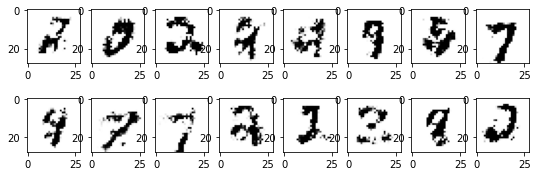

Epoch [13/20], d_loss: 0.6389, g_loss: 0.4001, D(x): 0.09, D(G(z)): 0.32


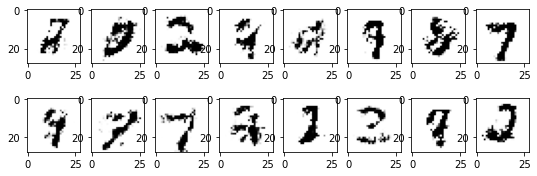

Epoch [14/20], d_loss: 0.6272, g_loss: 0.3711, D(x): 0.11, D(G(z)): 0.33


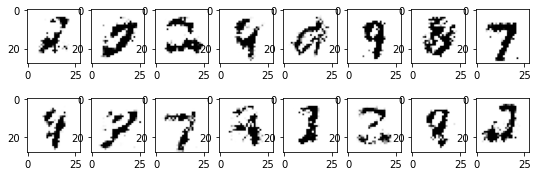

Epoch [15/20], d_loss: 0.6741, g_loss: 0.3428, D(x): 0.07, D(G(z)): 0.29


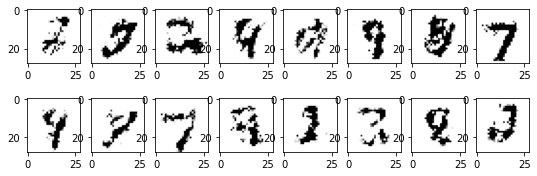

Epoch [16/20], d_loss: 0.5829, g_loss: 0.4141, D(x): 0.09, D(G(z)): 0.35


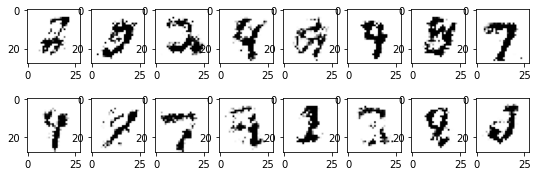

Epoch [17/20], d_loss: 0.6643, g_loss: 0.3685, D(x): 0.07, D(G(z)): 0.30


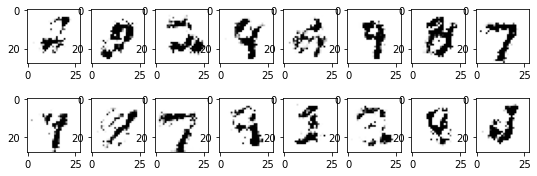

Epoch [18/20], d_loss: 0.6447, g_loss: 0.3789, D(x): 0.10, D(G(z)): 0.31


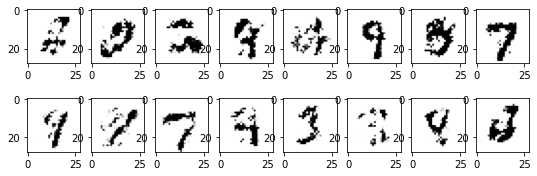

Epoch [19/20], d_loss: 0.6456, g_loss: 0.3572, D(x): 0.09, D(G(z)): 0.31


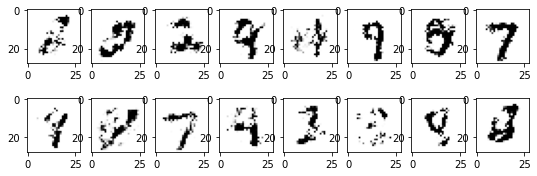

Epoch [20/20], d_loss: 0.6164, g_loss: 0.4118, D(x): 0.11, D(G(z)): 0.34


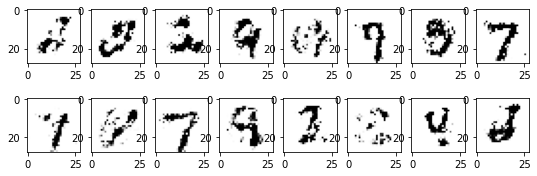

In [7]:
train(generator, discriminator, lr=0.001, num_epochs=20)

Las GAN son notoriamente difíciles de entrenar. Una dificultad es que una curva de entrenamiento ya no es tan útil como lo fue para un problema de aprendizaje supervisado. Las pérdidas del **generador** y del **discriminador** tienden a rebotar hacia arriba y hacia abajo ya que tanto el generador como el discriminador cambian con el tiempo. Ajustar los hiperparámetros también es mucho más difícil porque no tenemos la curva de entrenamiento para guiarnos. Los modelos GAN más nuevos como Wasserstein GAN intentan aliviar algunos de estos problemas.

Para agravar la dificultad del ajuste de hiperparámetros, las GAN también requieren mucho tiempo para entrenarse. Es tentador dejar de entrenar temprano, pero los efectos de los hiperparámetros pueden no notarse hasta más adelante en el entrenamiento.

Es posible notar que en las imágenes generadas por nuestro GAN simple que el modelo parece generar solo una pequeña cantidad de tipos de dígitos. Este fenómeno se denomina colapso de modo. Un generador puede optimizar *P(D identifica correctamente la imagen generada por G)* al aprender a generar un tipo de entrada (por ejemplo, un dígito) muy bien, ¡y no aprender a generar ningún otro dígito en absoluto!

Para evitar el colapso del modo, las variaciones más nuevas de GAN proporcionan al discriminador un pequeño conjunto de datos reales o falsos, en lugar de uno a la vez. Por lo tanto, un discriminador podría usar la variedad de datos generados como una característica para determinar si todo el pequeño conjunto de datos es real o falso.